## FODASSE

Test.csv é um dataset com

Train.csv é um dataset com

Meta.csv é um dataset com

Labels.csv é um dataset com 43 entradas e duas colunas em que a coluna ClassId é a coluna das classificações e SignName é o que a classificação representa

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import seaborn as sns

In [6]:
test_df = pd.read_csv("./Test.csv")
meta_df = pd.read_csv("./Meta.csv")
train_df = pd.read_csv("./Train.csv")
labels_df = pd.read_csv("./Labels.csv")

## Data Exploration

In [8]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [9]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [10]:
meta_df.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [7]:
labels_df.head() 

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


Ordenei o test_df para poder plotar um exemplo

In [4]:
test_df.sort_values(by=['ClassId'])

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
5945,49,51,6,5,44,46,0,Test/05945.png
7712,31,33,6,6,25,28,0,Test/07712.png
807,45,49,5,5,40,44,0,Test/00807.png
809,32,31,6,5,27,26,0,Test/00809.png
4512,31,34,5,5,26,29,0,Test/04512.png
...,...,...,...,...,...,...,...,...
4496,32,33,5,5,26,27,42,Test/04496.png
9593,27,28,6,5,22,23,42,Test/09593.png
11842,41,43,6,6,36,38,42,Test/11842.png
5786,49,53,6,5,44,48,42,Test/05786.png


In [11]:
img = cv.imread(test_df.loc[5945]['Path'])

In [12]:
img.shape[:2]

(51, 49)

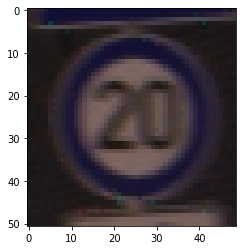

In [13]:
plt.imshow(img)

Aqui eu vejo a correlação para poder entender mais como as colunas se relacionam e assim ajudar na seleção dos atributos, no caso, vemos que largura e altura se corrolacionam entre si e com Roi.X1 em diante, e como não precisamos dessas informações, pois basta utilizar o .shape na matriz da imagem, é descartada na seleção.

<AxesSubplot:>

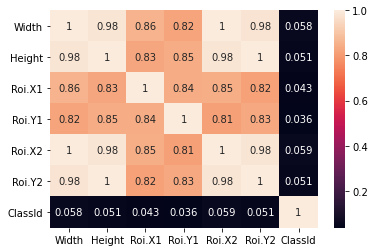

In [14]:
sns.heatmap(train_df.corr(), annot=True)

Vemos abaixo o desbalanceamento dos dados de treino e para resolver isto, podemos utilizar o oversampling para que todas as classes fiquem com o mesmo número de exemplos.

<AxesSubplot:xlabel='ClassId', ylabel='count'>

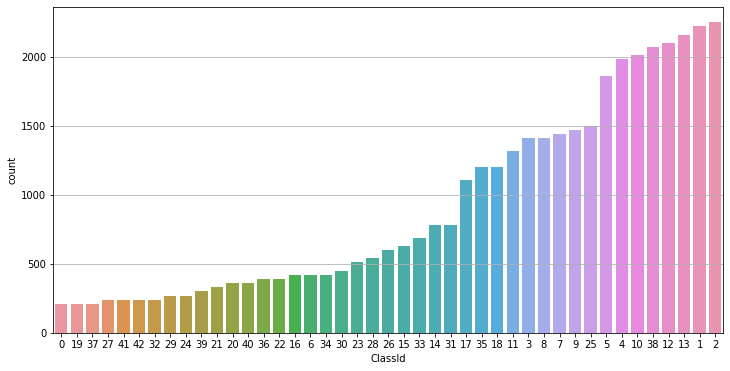

In [23]:
plt.figure(figsize=(12,6))
plt.grid()
sns.countplot(x='ClassId', data=train_df, order=train_df['ClassId'].value_counts(ascending=True).index)

E como vimos em cima, temos a mesma situação com os dados de teste.

<AxesSubplot:xlabel='ClassId', ylabel='count'>

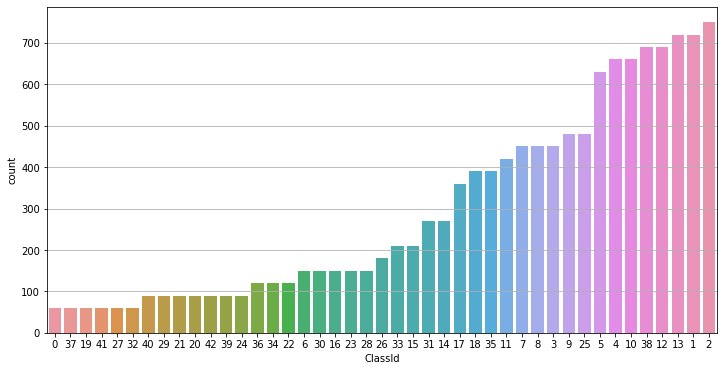

In [24]:
plt.figure(figsize=(12,6))
plt.grid()
sns.countplot(x='ClassId', data=test_df, order=test_df['ClassId'].value_counts(ascending=True).index)

Peguei uma imagem para ver como é a sua matriz e seu shape

In [75]:
img = cv.imread("Train/20/00020_00000_00000.png")
img

array([[[ 56,  51,  46],
        [ 56,  51,  48],
        [ 54,  51,  50],
        ...,
        [ 49,  48,  50],
        [ 51,  50,  50],
        [ 49,  49,  46]],

       [[ 56,  51,  47],
        [ 54,  49,  47],
        [ 54,  50,  49],
        ...,
        [ 49,  49,  53],
        [ 55,  57,  57],
        [ 50,  50,  46]],

       [[ 56,  51,  48],
        [ 52,  48,  46],
        [ 52,  49,  47],
        ...,
        [ 53,  53,  59],
        [ 61,  64,  64],
        [ 53,  54,  48]],

       ...,

       [[ 55,  51,  47],
        [ 54,  51,  49],
        [ 54,  52,  52],
        ...,
        [ 61,  77,  89],
        [ 62,  80,  91],
        [ 49,  62,  73]],

       [[ 56,  53,  49],
        [ 59,  55,  53],
        [ 56,  53,  53],
        ...,
        [ 70,  94, 107],
        [ 66,  93,  99],
        [ 55,  73,  72]],

       [[ 55,  52,  51],
        [ 61,  55,  54],
        [ 58,  54,  53],
        ...,
        [ 80, 112, 116],
        [ 61,  98,  98],
        [ 62,  85,  80]]

In [26]:
img.shape

(51, 49, 3)

Aqui eu vejo como está a distribuição das larguras da imagem de treino, e temos uma média de quase 50, estou vendo essas duas coisas para poder fazer um resize em todas as imagens, pois para passar como entrada na rede neural, é necessário estar do mesmo tamanho

<AxesSubplot:ylabel='Frequency'>

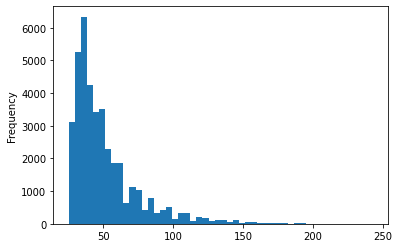

In [27]:
train_df['Width'].plot(kind='hist', bins=50)

In [28]:
train_df['Width'].mean()

50.83587951745773

E aqui eu vejo distribuição da altura das imagens

<AxesSubplot:ylabel='Frequency'>

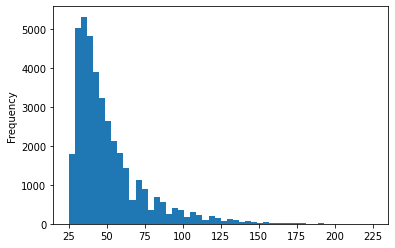

In [29]:
train_df['Height'].plot(kind='hist', bins=50)

In [30]:
train_df['Height'].mean()

50.328929582493814

Aqui eu faço um resize, para poder ver como fica a imagem após

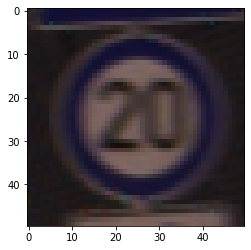

In [31]:
img = cv.resize(img,(50, 50), interpolation = cv.INTER_CUBIC)
plt.imshow(img)

Utilizo o info para ver se temos dados nulos

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


Aqui eu aplico uma função do openCV para transformar a imagem numa matriz numérica e adiciono uma coluna com essas matrizes

In [35]:
train_df['MatrixIMG'] = train_df['Path'].apply(lambda x: cv.imread(x))

In [36]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,MatrixIMG
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,"[[[56, 51, 46], [56, 51, 48], [54, 51, 50], [5..."
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,"[[[55, 50, 47], [55, 50, 49], [54, 50, 50], [5..."
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,"[[[57, 50, 51], [60, 51, 51], [57, 51, 50], [5..."
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,"[[[54, 49, 49], [55, 50, 49], [55, 50, 48], [5..."
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,"[[[55, 50, 50], [56, 50, 51], [54, 49, 51], [5..."


Após a transformação, eu faço um resize em todas as matrizes, para que fiquem do mesmo tamanho, (50,50)

In [37]:
train_df['MatrixIMG'] = train_df['MatrixIMG'].apply(lambda img: cv.resize(img,(50, 50), interpolation = cv.INTER_CUBIC))

Fiz uma função que transforma em escala de cinzas para que o shape (50,50,3) vá para (50,50)

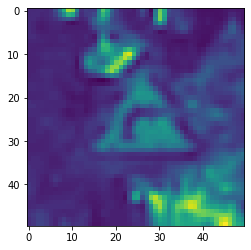

In [38]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

plt.imshow(rgb2gray(train_df['MatrixIMG'][0]))

In [39]:
train_df['MatrixIMG'][0].shape

(50, 50, 3)

In [40]:
rgb2gray(train_df['MatrixIMG'][0]).shape

(50, 50)

Assim, aplico a função para todas as imagens

In [41]:
train_df['MatrixIMG'] = train_df['MatrixIMG'].apply(rgb2gray)

Após isso, normalizo todas as imagens, para que uma feature da imagem não se saia por cima de outra

In [42]:
train_df['MatrixIMG'] = train_df['MatrixIMG'].apply(lambda x: x/255.0)

In [43]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,MatrixIMG
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,"[[0.2036054901960784, 0.2036054901960784, 0.20..."
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,"[[0.200578431372549, 0.20102549019607843, 0.20..."
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,"[[0.20353882352941174, 0.20588313725490195, 0...."
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,"[[0.197998431372549, 0.197998431372549, 0.2014..."
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,"[[0.20191960784313726, 0.20309176470588233, 0...."


Para o modelo de aprendizado, preferi utilizar a rede convolucional, poís possuímos muitos dados mesmo que estejam desbanlanceados, pensei em utilizar o KNN mas iria ser custoso e tem o problema de que, se eu não mostrar nenhum exemplo de alguma classe, ele nunca acertará

Utilizei a inicialização dos pesos em cada camada com a distribuição normal e um regularizador l1 para que meus pesos sejam baixos e implementei um early stopping para poder evitar o overfitting

In [146]:
model = tf.keras.models.Sequential([
     
     tf.keras.layers.Conv2D(10, (5,5), padding='same', input_shape=(50,50,1), kernel_initializer="normal", activation='relu', 
                           kernel_regularizer=tf.keras.regularizers.l1(0.01)),
     
     tf.keras.layers.MaxPooling2D((2,2)),
     
     tf.keras.layers.Conv2D(15, (5,5), activation='relu', kernel_initializer="normal"),
     
     tf.keras.layers.MaxPooling2D((2,2)),
     tf.keras.layers.Flatten(),
     
     tf.keras.layers.Dense(100, activation='relu', kernel_initializer="normal"),
     tf.keras.layers.Dense(50, activation='relu', kernel_initializer="normal"),
     tf.keras.layers.Dense(43, activation='softmax')
  
 ])
       
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])     

callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=10, verbose=1, mode="min") 

In [71]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 50, 50, 10)        260       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 25, 25, 10)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 21, 15)        3765      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 10, 10, 15)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1500)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               150100    
_________________________________________________________________
dense_13 (Dense)             (None, 50)               

Utilizei apenas a coluna das matrizes das imagens para o treinamento, as outras colunas não são necessárias

In [49]:
X_train = train_df['MatrixIMG']
y_train = train_df[['ClassId']].values

Coloquei cada exemplo em um array para poder utilizar o reshape, para colocar esse shape (X_train.shape[0], 50, 50, 1) , para podermos passar como entrada na rede

In [52]:
exemplos = []

for i in range(len(X_train)):
    exemplos.append(X_train[i])

In [53]:
X_train = np.array(exemplos)

In [54]:
X_train = X_train.reshape((X_train.shape[0], 50, 50, 1))

In [57]:
X_train.shape

(39209, 50, 50, 1)

In [59]:
y_train.shape

(39209, 1)

Como temos um problema de classificação multiclasse, temos que utilizar o one hot encoder, para que a saída da rede neural seja uma probabilidade de ser de alguma classe, onde tem a maior probabilidade é colocada como 1, e para a função de custo, que necessita que seja utilizado o one hot encoder para problemas multiclasses  

In [60]:
one_hot = OneHotEncoder(sparse=False)

In [61]:
y_train = one_hot.fit_transform(y_train)

In [62]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [67]:
history = model.fit(x=X_train, y=y_train, epochs=100, callbacks=[callback])

Epoch 1/10
1226/1226 [==============================] - 34s 28ms/step - loss: 1.6148 - accuracy: 0.5889
Epoch 2/10
1226/1226 [==============================] - 37s 30ms/step - loss: 0.4071 - accuracy: 0.9194
Epoch 3/10
1226/1226 [==============================] - 35s 29ms/step - loss: 0.2477 - accuracy: 0.9562
Epoch 4/10
1226/1226 [==============================] - 33s 27ms/step - loss: 0.1770 - accuracy: 0.9708
Epoch 5/10
1226/1226 [==============================] - 33s 27ms/step - loss: 0.1395 - accuracy: 0.9777
Epoch 6/10
1226/1226 [==============================] - 33s 27ms/step - loss: 0.1115 - accuracy: 0.9830
Epoch 7/10
1226/1226 [==============================] - 34s 28ms/step - loss: 0.0951 - accuracy: 0.9859
Epoch 8/10
1226/1226 [==============================] - 34s 28ms/step - loss: 0.0800 - accuracy: 0.9881
Epoch 9/10
1226/1226 [==============================] - 34s 28ms/step - loss: 0.0737 - accuracy: 0.9888
Epoch 10/10
1226/1226 [==============================] - 34s 28m

Vemos que o custo diminuiu sempre e a acurácia aumentou ate quase 100%, eu diria que é overfitting, mas temos que ver a validação

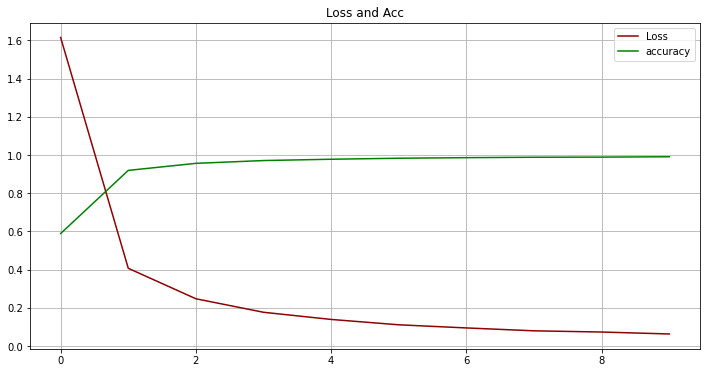

In [69]:
plt.figure(figsize=(12,6))
plt.grid()
plt.title('Loss and Acc')
plt.plot(history.history['loss'], color='darkred', label='Loss')
plt.plot(history.history['accuracy'], color='green', label='accuracy')
plt.legend()

Aplico os mesmos métodos que apliquei no treino

In [72]:
test_df['MatrixIMG'] = test_df['Path'].apply(lambda x: cv.imread(x))
test_df['MatrixIMG'] = test_df['MatrixIMG'].apply(lambda img: cv.resize(img,(50, 50), interpolation = cv.INTER_CUBIC))
test_df['MatrixIMG'] = test_df['MatrixIMG'].apply(rgb2gray)
test_df['MatrixIMG'] = test_df['MatrixIMG'].apply(lambda x: x/255.0)

In [73]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,MatrixIMG
0,53,54,6,5,48,49,16,Test/00000.png,"[[0.5718654901960785, 0.5711403921568626, 0.56..."
1,42,45,5,5,36,40,1,Test/00001.png,"[[0.2521760784313726, 0.29387647058823524, 0.2..."
2,48,52,6,6,43,47,38,Test/00002.png,"[[0.1520250980392157, 0.1566713725490196, 0.15..."
3,27,29,5,5,22,24,33,Test/00003.png,"[[0.4957462745098039, 0.42985372549019607, 0.3..."
4,60,57,5,5,55,52,11,Test/00004.png,"[[0.13389372549019607, 0.13434078431372548, 0...."


E faço os mesmos passos que fiz nos dados de treino

In [74]:
X_test = test_df['MatrixIMG']
y_test = test_df[['ClassId']].values

In [76]:
exemplos_test = []

for i in range(len(X_test)):
    exemplos_test.append(X_test[i])

In [77]:
X_test = np.array(exemplos_test)
X_test = X_test.reshape((X_test.shape[0], 50, 50, 1))

In [78]:
y_test = one_hot.fit_transform(y_test)

In [79]:
y_pred = model.predict(X_test)

In [80]:
label = [str(i) for i in range(43)]

Para poder utilizar o classification_report, foi usado a função argmax() com o axis=1, pois assim pegamos as linhas e vemos o índice do maior valor, que no caso é o número 1, e o índice em que se encontra é a classificação

In [81]:
y_test.argmax(axis=1)

array([16,  1, 38, ...,  6,  7, 10], dtype=int64)

In [82]:
y_pred.argmax(axis=1)

array([16,  1, 38, ...,  3,  7, 10], dtype=int64)

Notemos que a falta de dados influenciou na quantidade de acertos, na classe 27 temos um uma precisão muito baixa fora algumas classes que estão abaixo dos 70% de acerto

In [83]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=label))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91        60
           1       0.93      0.96      0.94       720
           2       0.93      0.96      0.94       750
           3       0.86      0.93      0.89       450
           4       0.97      0.92      0.95       660
           5       0.90      0.94      0.92       630
           6       1.00      0.83      0.91       150
           7       0.96      0.85      0.90       450
           8       0.82      0.96      0.89       450
           9       0.90      0.97      0.94       480
          10       0.99      0.97      0.98       660
          11       0.89      0.91      0.90       420
          12       0.97      0.98      0.97       690
          13       0.98      0.99      0.99       720
          14       0.97      0.94      0.96       270
          15       0.92      0.99      0.96       210
          16       1.00      0.98      0.99       150
          17       0.98    

Aqui eu comparo a classe verdadeira com a resposta do modelo

In [84]:
y_test[:10].argmax(axis=1)

array([16,  1, 38, 33, 11, 38, 18, 12, 25, 35], dtype=int64)

In [85]:
y_pred[:10].argmax(axis=1)

array([16,  1, 38, 33, 11, 38, 18, 12, 25, 35], dtype=int64)

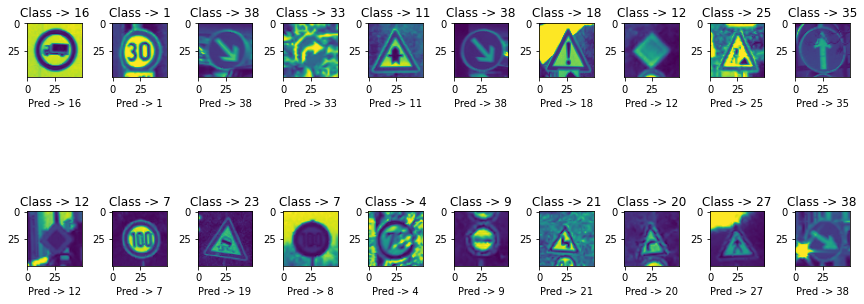

In [86]:
rows = 2
cols = 10
axes = []
fig = plt.figure(figsize=(12,6))

for a in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Class -> "+str(y_test[:20].argmax(axis=1)[a]))
    axes[-1].set_title(subplot_title)
    subplot_xlabel=("Pred -> "+str(y_pred[:20].argmax(axis=1)[a]))
    axes[-1].set_xlabel(subplot_xlabel)
    plt.imshow(X_test[a])
    

fig.tight_layout()    
plt.show()  # PEGAR OS LABELS(TEXTO)

Fiz uma função que passando o path da imagem, ele retorna a classificação dada pelo modelo e o que essa classificação quer dizer

Predict = 7 , Speed limit (100km/h)


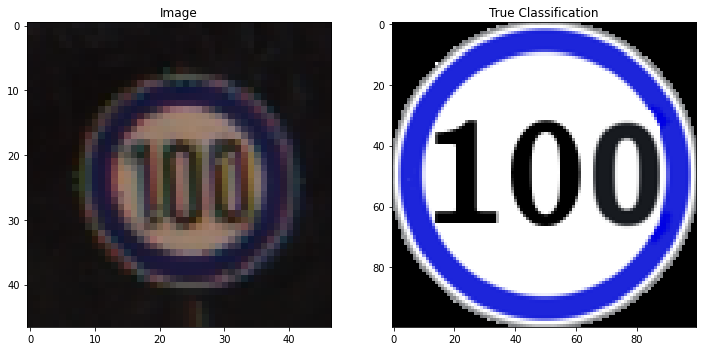

In [165]:
def prediction(path):
    img = cv.imread(path)
    axes = []
    fig = plt.figure(figsize=(12,6))
    
    axes.append( fig.add_subplot(1, 2, 1) )
    subplot_title=("Image")
    axes[-1].set_title(subplot_title)
    plt.imshow(img)
    
    res = rgb2gray(cv.resize(img,(50, 50), interpolation = cv.INTER_CUBIC))
    res = res.reshape(1,50,50,1)
    
    predict = model.predict(res).argmax()
    
    meta_class = meta_df[meta_df['ClassId'] == predict]['Path'].values[0]
    
    axes.append( fig.add_subplot(1, 2, 2) )
    subplot_title=("True Classification")
    axes[-1].set_title(subplot_title)
    plt.imshow(cv.imread(meta_class))
    
    text_class = labels_df[labels_df['ClassId'] == predict]['SignName'].values[0]
    
    print(f'Predict = {predict} , {text_class}')
    
prediction("Test/11000.png")    

Aqui eu soluciono o problema de desbanlanceamento de dados, tanto no treino, quanto no teste

In [103]:
from imblearn.over_sampling import SMOTE

Aqui, eu coloco cada instância num array para podermos ajeitar seu shape, multiplicando 50 por 50

In [114]:
exemplos = []

for i in range(len(train_df)):
    exemplos.append(train_df['MatrixIMG'][i])

exemplos2 = []

for i in range(len(test_df)):
    exemplos2.append(test_df['MatrixIMG'][i])

In [105]:
train = np.array(exemplos)

In [106]:
train = train.reshape(train.shape[0], -1)

X_smote e y_smote são os dados aumentados para treino e X_test_smote e y_test_smote para o teste, gerando o suficiente para que chegue na quantidade de instâncias da maior classe, no caso são 2250, então cada classe tera 2250 instâncias e após isso, voltamos ao shape original, e o random_state é 42 para que possa ser reproduzido com os mesmos resultados

In [128]:
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(train, train_df[['ClassId']].values)

In [129]:
X_smote.shape

(96750, 2500)

In [130]:
X_smote = X_smote.reshape(X_smote.shape[0],50,50,1)

In [131]:
X_smote.shape

(96750, 50, 50, 1)

In [132]:
y_smote = y_smote.reshape(y_smote.shape[0],1)

In [133]:
test = np.array(exemplos2)

In [134]:
test = test.reshape(test.shape[0],-1)
X_test_smote, y_test_smote = sm.fit_resample(test, test_df[['ClassId']].values)

In [135]:
y_test_smote = y_test_smote.reshape(y_test_smote.shape[0],1)

In [136]:
X_test_smote = X_test_smote.reshape(X_test_smote.shape[0],50,50,1)

In [137]:
y_smote = one_hot.fit_transform(y_smote)
y_test_smote = one_hot.fit_transform(y_test_smote)

In [138]:
y_smote

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [147]:
history_smoth = model.fit(x=X_smote, y=y_smote, epochs=10, callbacks=[callback])

Epoch 1/10
3024/3024 [==============================] - 95s 31ms/step - loss: 0.7086 - accuracy: 0.8310
Epoch 2/10
3024/3024 [==============================] - 93s 31ms/step - loss: 0.1586 - accuracy: 0.97530s - loss:
Epoch 3/10
3024/3024 [==============================] - 92s 30ms/step - loss: 0.0993 - accuracy: 0.9854
Epoch 4/10
3024/3024 [==============================] - 92s 30ms/step - loss: 0.0703 - accuracy: 0.9900
Epoch 5/10
3024/3024 [==============================] - 92s 31ms/step - loss: 0.0555 - accuracy: 0.99200s - loss: 0.0556  - ETA: 0s - loss: 0.0555 - accuracy: 0.
Epoch 6/10
3024/3024 [==============================] - 92s 30ms/step - loss: 0.0462 - accuracy: 0.9937
Epoch 7/10
3024/3024 [==============================] - 95s 32ms/step - loss: 0.0409 - accuracy: 0.9946
Epoch 8/10
3024/3024 [==============================] - 96s 32ms/step - loss: 0.0339 - accuracy: 0.9954
Epoch 9/10
3024/3024 [==============================] - 96s 32ms/step - loss: 0.0325 - accuracy: 0.9

In [148]:
y_pred_smoth = model.predict(X_test_smote)

Notamos que todas as classes estão acima dos 70%, comprovando que realmente melhorou ter balanceado os dados

In [149]:
print(classification_report(y_test_smote.argmax(axis=1), y_pred_smoth.argmax(axis=1), target_names=label))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       750
           1       0.94      0.94      0.94       750
           2       0.88      0.95      0.91       750
           3       0.87      0.91      0.89       750
           4       0.85      0.95      0.90       750
           5       0.82      0.87      0.84       750
           6       0.99      0.81      0.89       750
           7       1.00      0.77      0.87       750
           8       0.81      0.97      0.88       750
           9       0.78      0.98      0.87       750
          10       0.99      0.97      0.98       750
          11       0.91      0.90      0.90       750
          12       0.91      0.98      0.94       750
          13       0.97      0.99      0.98       750
          14       0.98      0.94      0.96       750
          15       0.99      0.99      0.99       750
          16       1.00      0.98      0.99       750
          17       1.00    

Predict = 14 , Stop


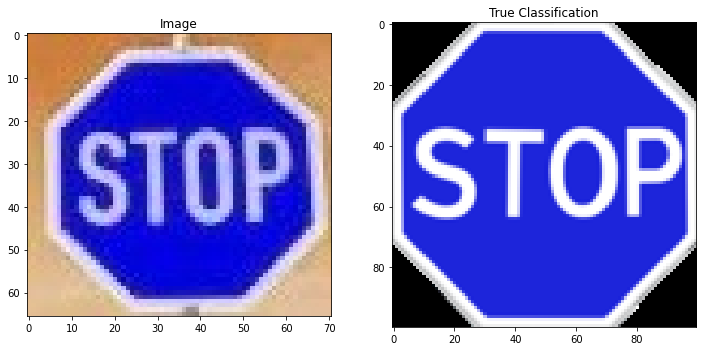

In [167]:
prediction('image_STOP.jpg')